# Practice: Information theory in Deep Learning.


## Question 1. Correlated Gaussian
#### (From Cover, T.M (1999). Elements of information theory. John Wiley & Sons)
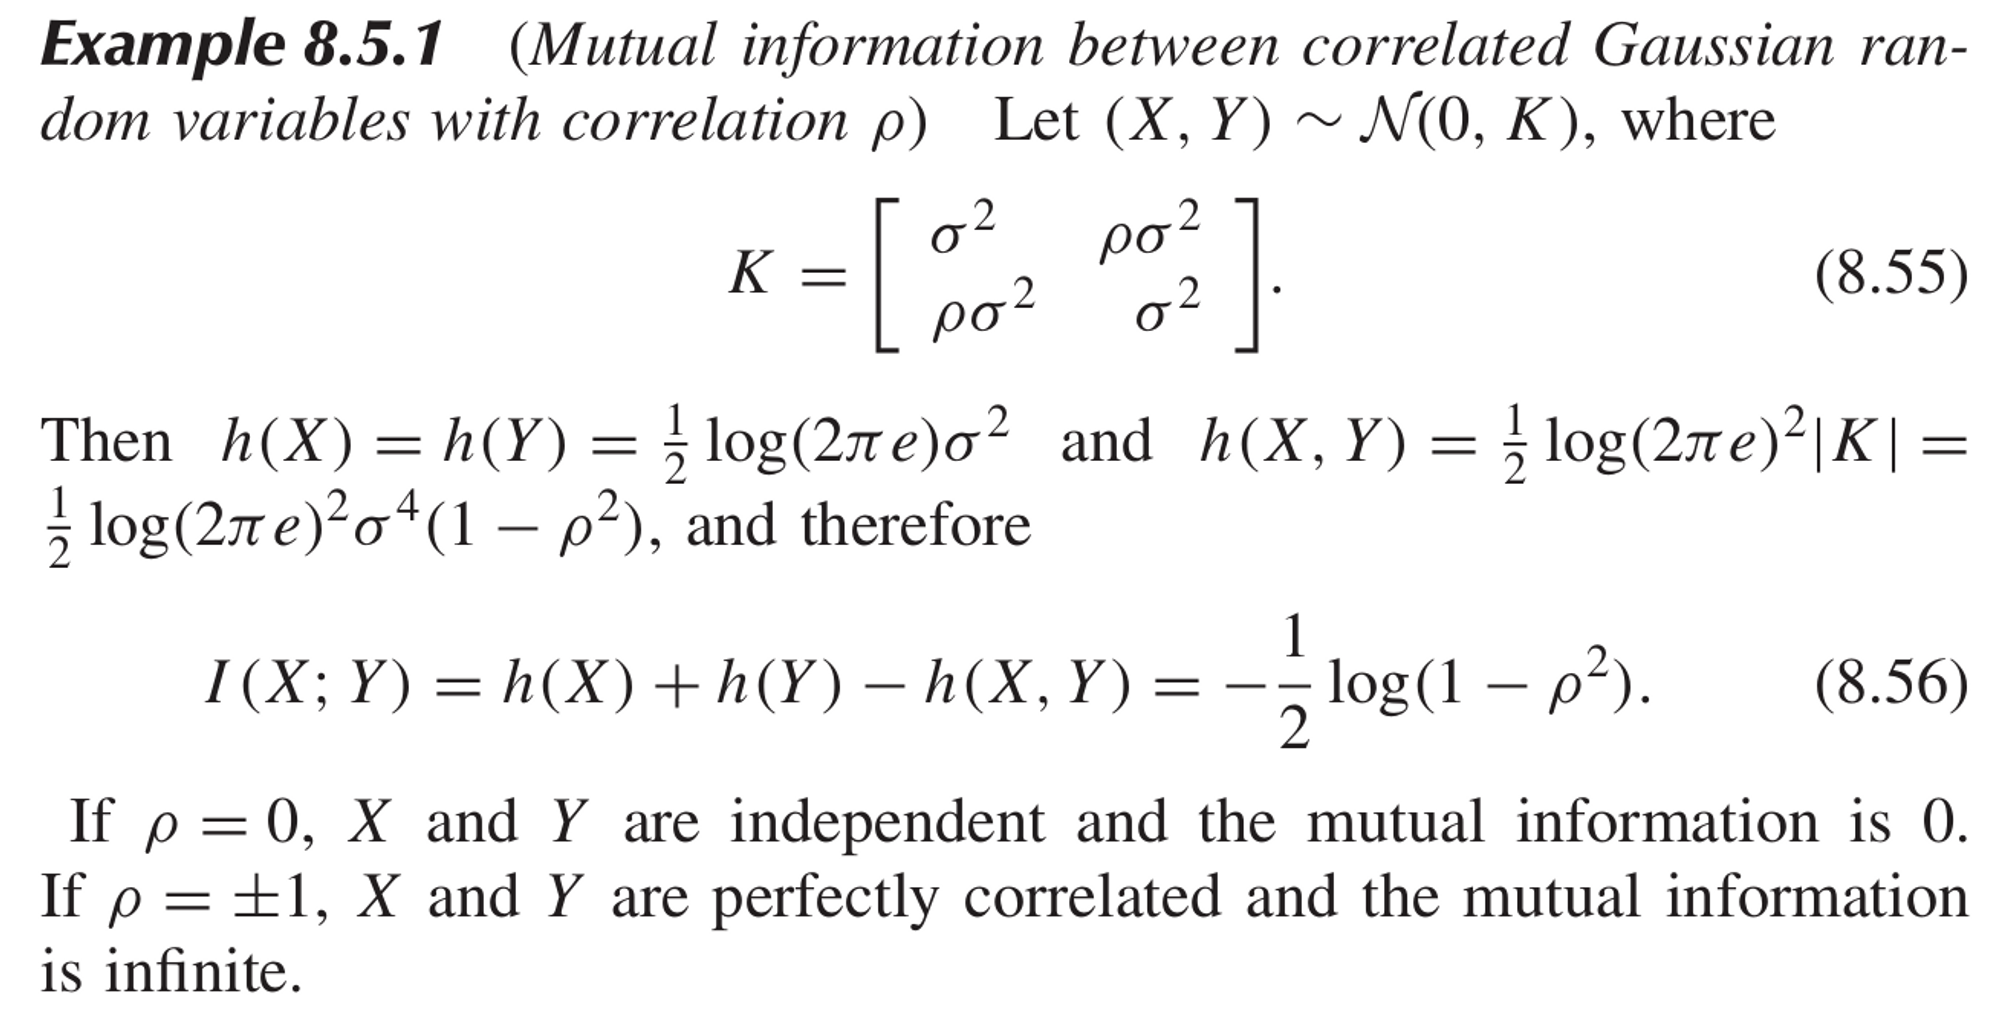
1. 코드에서 빈 부분을 채우세요.
2. 코드를 실행해서 결과를 얻으세요.
3. batch size 와 bound의 tightness (mi_true 와 측정한 값의 차이) 에 대해 분석하세요.

In [1]:
import os
!git clone https://github.com/ermongroup/smile-mi-estimator.git
os.rename('smile-mi-estimator', 'smile_mi_estimator')

Cloning into 'smile-mi-estimator'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 30 (delta 10), reused 24 (delta 8), pack-reused 0
Receiving objects: 100% (30/30), 1.01 MiB | 13.28 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [2]:
import numpy as np
import torch
from smile_mi_estimator.utils import SeparableCritic, sample_correlated_gaussian, mi_to_rho
# SeparableCritic(dim, hidden_dim=256, embed_dim=32, layers=2, activation='relu')
# sample_correlated_gaussian(rho, dim, batch_size, cubic=False)
# mi_to_rho(dim, mi_true)
from smile_mi_estimator.estimators import infonce_lower_bound

In [5]:
# estimate mutual information
dim=20
for mi_true in [2,4,6,8,10]:
    for batch_size in [64,128,256]:
        # define critic
        ####################
        # implement here
        ####################
        critic = SeparableCritic(dim, hidden_dim=256, embed_dim=32, layers=2, activation='relu').cuda()

        # optimizer for the critic
        opt_crit = torch.optim.Adam(critic.parameters(), lr=5e-4)

        rho = mi_to_rho(dim, mi_true)


        # train criric for 5000 iterations
        mis = []
        for iii in range(5000):
            # generate random variables x and y with mutual information of mi_true
            ####################
            # implement here
            ####################
            x, y = sample_correlated_gaussian(rho, dim , batch_size, cubic=False)


            # estimate mutual information using infonce lower bound
            ####################
            # implement here
            ####################
            scores = critic(x.cuda(), y.cuda())
            mi = infonce_lower_bound(scores)


            # the critic needs to be trained for tighter estimation. hence loss = -mi
            loss = -mi

            opt_crit.zero_grad()
            loss.backward()
            opt_crit.step()

            mis.append(mi.item())

        print('MI (True): {0:.2f}, Batch Size: {1}, MI (Estimated): {2:.2f}'.format(mi_true, batch_size, np.mean(mis[-100:])))

MI (True): 2.00, Batch Size: 64, MI (Estimated): 1.36
MI (True): 2.00, Batch Size: 128, MI (Estimated): 1.55
MI (True): 2.00, Batch Size: 256, MI (Estimated): 1.65
MI (True): 4.00, Batch Size: 64, MI (Estimated): 2.51
MI (True): 4.00, Batch Size: 128, MI (Estimated): 2.88
MI (True): 4.00, Batch Size: 256, MI (Estimated): 3.13
MI (True): 6.00, Batch Size: 64, MI (Estimated): 3.28
MI (True): 6.00, Batch Size: 128, MI (Estimated): 3.75
MI (True): 6.00, Batch Size: 256, MI (Estimated): 4.20
MI (True): 8.00, Batch Size: 64, MI (Estimated): 3.65
MI (True): 8.00, Batch Size: 128, MI (Estimated): 4.28
MI (True): 8.00, Batch Size: 256, MI (Estimated): 4.85
MI (True): 10.00, Batch Size: 64, MI (Estimated): 3.89
MI (True): 10.00, Batch Size: 128, MI (Estimated): 4.55
MI (True): 10.00, Batch Size: 256, MI (Estimated): 5.19


## Question 2. Alignment and Uniformity
1. 코드에서 빈 부분을 채우세요.
2. 코드를 실행해서 결과를 얻으세요.
3. randon init 모델과 pre-trained 모델의 alignment와 uniformity에 대해서 분석하세요.

In [6]:
import torch
import torchvision
import numpy as np

In [7]:
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input[0]
    def close(self):
        self.hook.remove()


class MultiTransform(object):
    def __init__(self, transform_list):
        self.transform_list = transform_list
    def __call__(self, input_img):
        return [each_transform(input_img) for each_transform in self.transform_list]


color_jitter = torchvision.transforms.ColorJitter(brightness = 0.4, contrast = 0.4, saturation = 0.4, hue = 0.1)
transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomResizedCrop(size=32),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomApply([color_jitter], p=0.8),
            torchvision.transforms.RandomGrayscale(p=0.2),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
            ])
dataset_valid = torchvision.datasets.CIFAR10('./data/cifar10', train=False, transform=MultiTransform([transform]*2), target_transform=None, download=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, shuffle=False, pin_memory=True, batch_size = 256, num_workers=8)



def generate_representations_for_two_views(model, hook_reps, data_loader):
    rep0_list = []
    rep1_list = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            _ = model(inputs[0].to('cuda'))
            rep0_list.append(hook_reps.input)

            _ = model(inputs[1].to('cuda'))
            rep1_list.append(hook_reps.input)

    return torch.cat(rep0_list), torch.cat(rep1_list)

100%|██████████| 170498071/170498071 [00:04<00:00, 42240585.81it/s]


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
def align_loss(x, y, alpha=2):
    ####################
    # implement here
    ####################
    x = torch.nn.functional.normalize(x)
    y = torch.nn.functional.normalize(y)
    return (x-y).norm(p=2, dim=1).pow(alpha).mean()

def uniform_loss(x, t=2):
    ####################
    # implement here
    ####################
    x = torch.nn.functional.normalize(x)
    return torch.pdist(x, p=2).pow(2).mul(-t).exp().mean().log()

for model_name in ['resnet18','resnet34','resnet50','resnet101','resnet152']:
    for pretrained in [False, True]:
        model = torchvision.models.__dict__[model_name](pretrained=pretrained)
        model.eval()
        model.cuda()
        hook_fc = Hook(model.fc)

        alignment_loss, uniformity_loss = np.inf, np.inf
        while (not np.isfinite(alignment_loss)) or (not np.isfinite(uniformity_loss)):
            reps0, reps1 = generate_representations_for_two_views(model, hook_fc, loader_valid)
            alignment_loss = align_loss(reps0, reps1).item()
            uniformity_loss = uniform_loss(reps0).item()

        print('pretrained: {0}, model: {1}, align_loss: {2:.2f}, uniform_loss: {3:.2f}'.format(pretrained, model_name, alignment_loss, uniformity_loss))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


pretrained: False, model: resnet18, align_loss: 0.15, uniform_loss: -0.37


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 58.5MB/s]


pretrained: True, model: resnet18, align_loss: 0.76, uniform_loss: -2.33
pretrained: False, model: resnet34, align_loss: 0.05, uniform_loss: -0.12


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 63.8MB/s]


pretrained: True, model: resnet34, align_loss: 0.65, uniform_loss: -2.06
pretrained: False, model: resnet50, align_loss: 0.02, uniform_loss: -0.04


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 55.3MB/s]


pretrained: True, model: resnet50, align_loss: 0.80, uniform_loss: -2.35
pretrained: False, model: resnet101, align_loss: 0.00, uniform_loss: -0.00


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:02<00:00, 71.2MB/s]


pretrained: True, model: resnet101, align_loss: 0.85, uniform_loss: -2.47
pretrained: False, model: resnet152, align_loss: 0.00, uniform_loss: -0.00


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:03<00:00, 61.2MB/s]


pretrained: True, model: resnet152, align_loss: 0.81, uniform_loss: -2.38
